In [5]:
import pandas as pd
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [6]:
cd

/root


In [7]:
bd=pd.read_excel('/gdrive/MyDrive/CE/BDEX to UDM Data Mapping - May 13, 2021.xlsx')

In [8]:
bd['udm_user_found']=bd['UDM Consumer User ID'].map({'No Match Found': False}).fillna(True)

In [9]:
met_dict= {'email_address': 'count', 'udm_user_found': 'sum'}
bf= bd.loc[bd.Vendor=='DI'].groupby('Client Account AS400 ID').agg(met_dict).reset_index()
bf.columns=['as400id', 'emails', 'users_found']
bf['opportunity_size']= bf.emails- bf.users_found
bf['bdex']= 'Y'

In [10]:
mf= pd.read_csv('/gdrive/MyDrive/CE/nummc.csv')

In [11]:
mf.columns=['as400id', 'machine_count']

In [12]:
bf.shape

(2215, 5)

In [13]:
bf.merge(mf, how='inner', on= 'as400id').shape

(2202, 6)

In [14]:
df=pd.read_csv('/gdrive/MyDrive/CE/uupm.csv')
df.columns= ['as400id', 'payment_type', 'weeknum', 'uniq_transactors', 'amt']

In [15]:
ditch=[]
for a in df.as400id:
  try:
    int(a)
  except:
    ditch.append(a)
ditch.append('-303934')
ditch.append('0')
ditch.append('000000000')
ditch.append('999999999')
ditch = set(ditch)

In [16]:
df1=df.loc[~df.as400id.isin(ditch)]

In [17]:
df11=df1.loc[df.weeknum <= 16].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df11.columns=['UniqTxntrAll', 'AmtAll']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [18]:
df12=df1.loc[(df.weeknum <= 16) & (df.payment_type=='App')].groupby('as400id')['uniq_transactors', 'amt'].sum().divide(16)
df12.columns=['UniqTxntrApp', 'AmtApp']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [19]:
df2=pd.concat([df11,df12], axis=1, join='outer').fillna(0).reset_index()
df2.columns= ['as400id', 'UniqTxntrAll', 'AmtAll', 'UniqTxntrApp', 'AmtApp']

In [20]:
import numpy as np
df2['UnitVendAlldollar']= df2.AmtAll/(np.where(df2.UniqTxntrAll==0, 1, df2.UniqTxntrAll)*100.0)
df2['UnitVendAppdollar']= df2.AmtApp/(np.where(df2.UniqTxntrApp==0, 1, df2.UniqTxntrApp)*100.0)

In [21]:
df2.head()

,as400id,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar
0,03001478,45.1875,31829.6875,18.9375,13735.9375,7.043914,7.253300
1,03021438,8.2500,4895.6250,8.2500,4895.6250,5.934091,5.934091
2,04020589,1.1250,2579.6875,1.1250,235.9375,22.930556,2.097222
3,04318891,0.0000,109.3750,0.0000,0.0000,1.093750,0.000000
4,04334902,1.2500,1010.9375,1.2500,421.8750,8.087500,3.375000


In [22]:
df3=bf.merge(mf, how='inner', on= 'as400id').merge(df2, how='inner', on='as400id')

In [23]:
df3

,as400id,emails,users_found,opportunity_size,bdex,machine_count,UniqTxntrAll,AmtAll,UniqTxntrApp,AmtApp,UnitVendAlldollar,UnitVendAppdollar
0,10824,14,2,12,Y,4,7.6250,6878.1250,7.6250,6437.5000,9.020492,8.442623
1,1100318,162,6,156,Y,12,11.8125,12281.2500,5.3750,5681.2500,10.396825,10.569767
2,1100331,51,3,48,Y,6,6.6875,7771.8750,1.6250,1479.6875,11.621495,9.105769
3,1100489,8,0,8,Y,7,3.3125,4950.0000,3.3125,2150.0000,14.943396,6.490566
4,1100690,28,0,28,Y,16,46.6875,41767.1875,22.5625,21192.1875,8.946118,9.392659
...,...,...,...,...,...,...,...,...,...,...,...,...
2134,920182,13,0,13,Y,4,5.6250,5895.3125,1.9375,1460.9375,10.480556,7.540323
2135,920187,27,0,27,Y,8,11.7500,15425.0000,4.2500,3514.0625,13.127660,8.268382
2136,920830,571,3,568,Y,24,30.4375,20656.2500,11.7500,8385.9375,6.786448,7.136968
2137,9279,226,13,213,Y,8,7.9375,12790.6250,4.2500,5271.8750,16.114173,12.404412


In [31]:
df3['AlltxntrperMc']= df3.UniqTxntrAll/df3.machine_count

In [25]:
df3.AlltxntrperMc.describe()

count    2139.000000
mean        1.397417
std         1.076453
min         0.000000
25%         0.593750
50%         1.190104
75%         1.928646
max         7.505208
Name: AlltxntrperMc, dtype: float64

,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
AlltxntrperMc,2139,1.39742,1.07645,0,0.59375,1.1901,1.92865,7.50521


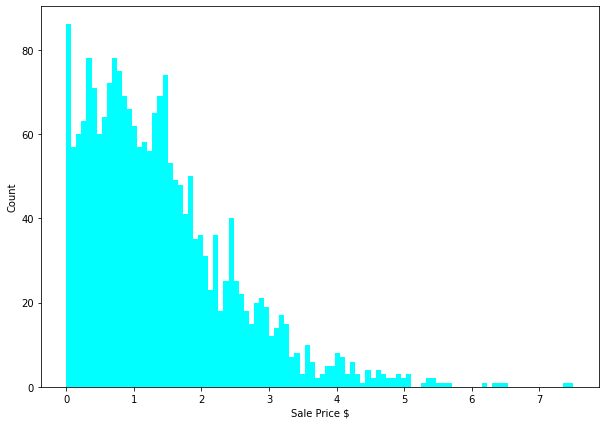

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.hist(df3.AlltxntrperMc, color='cyan', bins=100,log=False, histtype='bar')
# plt.hist(df3.AlltxntrperMc.sample(frac=.4, replace=False, random_state=42, axis=0), color='orange', bins=100,log=False, histtype='bar')
plt.xlabel('Sale Price $')
plt.ylabel('Count')
# plt.axvline(df3.AlltxntrperMc.mean(), color='red', linestyle='solid', linewidth=1.5)
# plt.axvline(df3.AlltxntrperMc.median(), color='brown', linestyle='solid', linewidth=1.5)
# plt.axvline(df3.AlltxntrperMc.describe().loc['25%'], color='brown', linestyle='dashed', linewidth=1)
# plt.axvline(df3.AlltxntrperMc.describe().loc['75%'], color='brown', linestyle='dashed', linewidth=1)
# plt.axvline(df3.AlltxntrperMc.describe().loc['mean']+ 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# # plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.describe().loc['std'], color='purple', linestyle='dashed', linewidth=1)
# # plt.axvline(df3.AlltxntrperMc.describe().loc['mean']- 3*df3.AlltxntrperMc.loc['std'], color='purple', linestyle='dashed', linewidth=1)
# plt.show()
df3.AlltxntrperMc.describe().reset_index().T

In [27]:
def add_campaignflag(df, splits=[.4,.4,.2]):
  ixs= np.arange(df.shape[0])
  np.random.shuffle(ixs)
  np.random.seed(42)
  df['camp_flag']= None
  start=0
  for i,s in enumerate(splits):
    stop= start+int(round(s*len(df),0))
    df['camp_flag'].iloc[start:stop]= 'split_'+str(i)
    start = stop
  return(df)

In [28]:
df4=add_campaignflag(df3)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [29]:
df4.camp_flag.value_counts()

split_1    856
split_0    856
split_2    427
Name: camp_flag, dtype: int64

In [30]:
df4.groupby('camp_flag')['AlltxntrperMc'].agg('describe')

,count,mean,std,min,25%,50%,75%,max
camp_flag,,,,,,,,
split_0,856.0,1.475379,1.063277,0.0,0.687500,1.281250,2.003906,6.406250
split_1,856.0,1.284345,1.018465,0.0,0.478365,1.079928,1.805804,6.179688
split_2,427.0,1.467803,1.192361,0.0,0.617488,1.166667,2.053571,7.505208


# Other Stuff

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_train=0.6, frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return(df_train, df_val, df_test)

In [1]:
import pandas as pd

positions = {"least": 0.277220, "left": 0.250000, "right": 0.250000, "left-center": 0.141244, "right-center": 0.081536}
data = [['title-{}-{}'.format(i, position), position] for i in range(1000) for position in positions.keys()]
frame = pd.DataFrame(data=data, columns=['title', 'position'])
print(frame.shape)


def sample(obj, replace=False, total=1000):
    return obj.sample(n=int(positions[obj.name] * total), replace=replace)

result = frame.groupby('position', as_index=False).apply(sample).reset_index(drop=True)
print(result.groupby('position').agg('count'))

(5000, 2)
              title
position           
least           277
left            250
left-center     141
right           250
right-center     81


In [3]:
frame.shape

(5000, 2)